## Junior quant task Report 
**by Ivan Pavlovich** 

### Contents  

* Task description 
* Data preprocessing
* Data split and Metrics function
* Applying linear regression
* Feature engineering
  * The inside quotes
  * Orderbook Imbalances
* Normalization
* Regularization 
  * L1 Lasso regression
  * L2 Ridge regression
* Test prices forecasting  
* Conclusion 
* References
 


### Task description

Вам предлагается решить задачу восстановления торговой стратегии наших конкурентов по данным. В файле train.txt даны 9000 пар (стакан; цена). Ниже каждого стакана указана та цена, по которой алгоритм, глядя на стакан, готов купить или продать. Обратите внимание, что алгоритм может выбрать цену не только из 20 предложенных в тестовом стакане, но и цену которой там нет, кратную 5. То, что с заявкой происходит далее - значения не имеет. Все стаканы между собой не связаны и были выбраны в случайные моменты времени. Вам надо придумать свой алгоритм, который бы на контрольной выборке стаканов выбрал те же цены, что и исходный алгоритм. Результат будет оцениваться по числу точных совпадений ваших цен с искомыми. В качестве результата мы ожидаем увидеть: 1) 25 пар (стакан; цена) - нужно заполнить файл test.txt в таком же формате как train.txt (просто добавить пропущенные цены) 2) Отчет, где изложены ваши мысли в свободной форме и сам алгоритм

Почитать про стакан можно тут https://ru.wikipedia.org/wiki/Биржевой_стакан и тут https://www.machow.ski/posts/2021-07-18-introduction-to-limit-order-books/

### Data preprocessing

First of all, let's import the required libraries

In [15]:
import numpy as np # https://numpy.org
import pandas as pd # https://pandas.pydata.org

import matplotlib.pyplot as plt # https://matplotlib.org
from tqdm import tqdm # https://tqdm.github.io

from sklearn.preprocessing import StandardScaler, RobustScaler # https://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.model_selection import train_test_split # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.linear_model import LinearRegression, Lasso, Ridge # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.metrics import mean_squared_error, mean_absolute_error # https://scikit-learn.org/stable/modules/model_evaluation.html

import warnings # this helps to get rid of plt warnings  
import matplotlib.cbook 
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation) 

pd.set_option('display.max_columns', None) # this let us see all columns in dataframe 

Now we can read the data and move on

In [16]:
col_names = ['Price','Amount','Order']
train = pd.read_csv('train.txt', sep='\t', names=col_names) # reading the data
test = pd.read_csv('test.txt',sep='\t', names=col_names) # reading the data

In [17]:
train.shape # raw data size

(378000, 3)

In [18]:
len(train[train['Price'].str.contains('=')]) # => 9000 independent order books in the dataset 

9000

In [19]:
train = train[~train['Price'].str.contains('=')] # getting rid of the separators
test = test[~test['Price'].str.contains('=')]

In [20]:
train['Order'] = train['Order'].apply(lambda x: 0 if x=='Sell' else 1) # categorical feature to binary 
test['Order'] = test['Order'].apply(lambda x: 0 if x=='Sell' else 1)

The each orderbook contains 40 tuples - price | amount | order. Due to the fact that model is meant to predict only one target variable for these 40 rows, we should modify the dataset and make vector conversions, so that each vector(row) will contain 40 * 3 features, and its final dimension would be **1x120**.

Hence, final matrix dimension will be **9000x120**. We also should include the predicted order(buy/sell), so **9000x121**.

In [21]:
X_train, y_train = np.zeros((9000,1+120)), np.zeros(9000) # creating empty numpy arrays

In [22]:
orderbook_counter = 0 #  two counters for orderbooks and orders respectively 
order_counter = 0 

for i in tqdm(range(train.shape[0])): # filling the np.arrays 
    row = train.iloc[i]
    if 'price' not in row['Price']:
        X_train[orderbook_counter,order_counter:order_counter+3] = row.to_numpy() # the 'step' for each order is 3
        order_counter += 3
    elif 'price' in row['Price']:
        pred_order = row['Price'].split(':')[0]
        c = [0 if 'Sell' in pred_order else 1]
        X_train[orderbook_counter,-1] = c[0]
        y_train[orderbook_counter] = float(row['Price'].split(':')[1])
        orderbook_counter += 1
        order_counter = 0

100%|████████████████████████████████| 369000/369000 [00:18<00:00, 20113.14it/s]


In [23]:
columns_ = [] # creating the title for the final matrix
for i in range(40):
    price, amount, order = 'price_' + str(i), 'amount_' + str(i), 'order_' + str(i)
    columns_.extend([price, amount, order])

In [24]:
data = pd.DataFrame(X_train, columns=columns_ + ['pred_order'])

In [25]:
data # the dataset is ready 

,price_0,amount_0,order_0,price_1,amount_1,order_1,price_2,amount_2,order_2,price_3,amount_3,order_3,price_4,amount_4,order_4,price_5,amount_5,order_5,price_6,amount_6,order_6,price_7,amount_7,order_7,price_8,amount_8,order_8,price_9,amount_9,order_9,price_10,amount_10,order_10,price_11,amount_11,order_11,price_12,amount_12,order_12,price_13,amount_13,order_13,price_14,amount_14,order_14,price_15,amount_15,order_15,price_16,amount_16,order_16,price_17,amount_17,order_17,price_18,amount_18,order_18,price_19,amount_19,order_19,price_20,amount_20,order_20,price_21,amount_21,order_21,price_22,amount_22,order_22,price_23,amount_23,order_23,price_24,amount_24,order_24,price_25,amount_25,order_25,price_26,amount_26,order_26,price_27,amount_27,order_27,price_28,amount_28,order_28,price_29,amount_29,order_29,price_30,amount_30,order_30,price_31,amount_31,order_31,price_32,amount_32,order_32,price_33,amount_33,order_33,price_34,amount_34,order_34,price_35,amount_35,order_35,price_36,amount_36,order_36,price_37,amount_37,order_37,price_38,amount_38,order_38,price_39,amount_39,order_39,pred_order
0,130990.0,41.0,0.0,130985.0,16.0,0.0,130980.0,22.0,0.0,130975.0,18.0,0.0,130970.0,13.0,0.0,130965.0,13.0,0.0,130960.0,8.0,0.0,130955.0,21.0,0.0,130950.0,43.0,0.0,130945.0,20.0,0.0,130940.0,31.0,0.0,130935.0,10.0,0.0,130930.0,5.0,0.0,130925.0,12.0,0.0,130920.0,4.0,0.0,130915.0,8.0,0.0,130910.0,6.0,0.0,130905.0,111.0,0.0,130900.0,32.0,0.0,130895.0,14.0,0.0,130880.0,4.0,1.0,130875.0,9.0,1.0,130870.0,52.0,1.0,130865.0,6.0,1.0,130860.0,8.0,1.0,130855.0,28.0,1.0,130850.0,22.0,1.0,130845.0,30.0,1.0,130840.0,22.0,1.0,130835.0,19.0,1.0,130830.0,22.0,1.0,130825.0,22.0,1.0,130820.0,96.0,1.0,130815.0,20.0,1.0,130810.0,50.0,1.0,130805.0,44.0,1.0,130800.0,46.0,1.0,130795.0,47.0,1.0,130790.0,31.0,1.0,130785.0,13.0,1.0,0.0
1,130995.0,34.0,0.0,130990.0,22.0,0.0,130985.0,4.0,0.0,130980.0,10.0,0.0,130975.0,26.0,0.0,130970.0,11.0,0.0,130965.0,22.0,0.0,130960.0,21.0,0.0,130955.0,11.0,0.0,130950.0,57.0,0.0,130945.0,23.0,0.0,130940.0,17.0,0.0,130935.0,12.0,0.0,130930.0,5.0,0.0,130925.0,15.0,0.0,130920.0,11.0,0.0,130915.0,14.0,0.0,130910.0,14.0,0.0,130905.0,46.0,0.0,130900.0,25.0,0.0,130885.0,8.0,1.0,130880.0,8.0,1.0,130875.0,13.0,1.0,130870.0,18.0,1.0,130865.0,4.0,1.0,130860.0,10.0,1.0,130855.0,24.0,1.0,130850.0,33.0,1.0,130845.0,11.0,1.0,130840.0,16.0,1.0,130835.0,19.0,1.0,130830.0,29.0,1.0,130825.0,23.0,1.0,130820.0,88.0,1.0,130815.0,17.0,1.0,130810.0,55.0,1.0,130805.0,48.0,1.0,130800.0,46.0,1.0,130795.0,53.0,1.0,130790.0,25.0,1.0,0.0
2,131030.0,11.0,0.0,131025.0,11.0,0.0,131020.0,42.0,0.0,131015.0,15.0,0.0,131010.0,43.0,0.0,131005.0,20.0,0.0,131000.0,83.0,0.0,130995.0,38.0,0.0,130990.0,27.0,0.0,130985.0,15.0,0.0,130980.0,8.0,0.0,130975.0,14.0,0.0,130970.0,18.0,0.0,130965.0,22.0,0.0,130960.0,11.0,0.0,130955.0,12.0,0.0,130950.0,6.0,0.0,130945.0,25.0,0.0,130940.0,1.0,0.0,130935.0,4.0,0.0,130920.0,5.0,1.0,130915.0,7.0,1.0,130910.0,1.0,1.0,130905.0,8.0,1.0,130900.0,35.0,1.0,130895.0,10.0,1.0,130890.0,3.0,1.0,130885.0,22.0,1.0,130880.0,18.0,1.0,130875.0,12.0,1.0,130870.0,6.0,1.0,130865.0,23.0,1.0,130860.0,18.0,1.0,130855.0,32.0,1.0,130850.0,86.0,1.0,130845.0,15.0,1.0,130840.0,30.0,1.0,130835.0,12.0,1.0,130830.0,8.0,1.0,130825.0,9.0,1.0,0.0
3,131045.0,19.0,0.0,131040.0,5.0,0.0,131035.0,3.0,0.0,131030.0,11.0,0.0,131025.0,11.0,0.0,131020.0,43.0,0.0,131015.0,15.0,0.0,131010.0,43.0,0.0,131005.0,22.0,0.0,131000.0,84.0,0.0,130995.0,35.0,0.0,130990.0,27.0,0.0,130985.0,13.0,0.0,130980.0,6.0,0.0,130975.0,13.0,0.0,130970.0,17.0,0.0,130965.0,21.0,0.0,130960.0,14.0,0.0,130955.0,10.0,0.0,130950.0,2.0,0.0,130940.0,1.0,1.0,130935.0,23.0,1.0,130930.0,2.0,1.0,130925.0,6.0,1.0,130920.0,5.0,1.0,130915.0,13.0,1.0,130905.0,37.0,1.0,130900.0,35.0,1.0,130895.0,13.0,1.0,130890.0,3.0,1.0,130885.0,22.0,1.0,130880.0,27.0,1.0,130875.0,12.0,1.0,130870.0,8.0,1.0,130865.0,22.0,1.0,130860.0,19.0,1.0,130855.0,30.0,1.0,130850.0,85.0,1.0,130845.0,15.0,1.0,130840.0,26.0,1.0,1.0
4,131035.0,3.0,0.0,131030.0,1

### Data split and Metrics function

In [26]:
X_tt,X_val,y_tt,y_val = train_test_split(X_train,y_train, test_size=0.3,random_state=17)

Below we will often use different models, so we will use this function to avoid making a mess of the code. It takes the model and the loss function as arguments. Then it fits the model and returns an error. It is also important to note that, according to the assignment, the predicted value must be a multiple of 5. So the function makes the model predict values divided by 5, and then multiplies the results by 5.

In [27]:
def metrics(model, loss): # function to make the code look nice and make the predicted value a multiple of 5
    
    model.fit(X_tt, y_tt / 5) # according to the task the price should be a multiple of 5 
    
    pred_tt = 5 * model.predict(X_tt).astype(np.int32) # it's important to convert float number to int to avoid errors in calculations
    pred_val = 5 * model.predict(X_val).astype(np.int32)

    error_train = loss(y_tt,pred_tt)
    error_test = loss(y_val,pred_val)

    print('Results on train set: {}'.format(error_train))
    print('Results on test set: {}'.format(error_test))
    
    return [error_train,error_test]

### Applying linear regression 

In [28]:
linreg = LinearRegression()

Let's estimate regression loss using **Mean Abslute Error(MAE)**. We're predicting a price, hence MAE is quite suitable for quantitative feature and the results are easy to interpret. 

$$
Mean Abslute Error(MAE)=\frac{\sum_{i=1}^{n}|y_i-\hat{y_i}| }{n}
$$

In [29]:
metrics(linreg,mean_absolute_error)

Results on train set: 16.56031746031746
Results on test set: 16.54259259259259


[16.56031746031746, 16.54259259259259]

### Feature engineering

As the best practice quants use multiple features to fit the models, however most of them require very precise and varied data such as tick size, strict timing, different asset valuations on different markets e.t.c

All order books have the same size and were taken during periods of low volatility, when (effective) spreads are really small.

Let's try to create few fetures based only on orderbook liqidity. 

#### The inside quotes

$$
Spread = \frac{p_{a}-p_{b}}{p_{a}}*100\\
$$


Best ask price -  $ p_{a}$


Best bid price -  $ p_{b}$

The inside quotes, which are also known as the Best Bid and Offer or BBO, are the highest bid, and lowest ask, in the order book. They are the prices at which the next market buy (with the best offer) or market sell (with the best bid) will transact. Traders constantly reshuffling their bids and asks, and other traders interacting with orders, is what causes prices to move. In an actively traded stock, the bid and ask prices—and the quantities of shares available at those prices—will change by the second.

In [80]:
data['spread %'] = ((data['price_19'] - data['price_20'])/data['price_19'])*100

#### Orderbook Imbalances

$$ 
IMB^{a,i}_{t} = \frac{p^{i}_{a,t}(N_{i})}{p^{i}_{a,t}(1)}*1000\\
$$
$$ 
IMB^{b,i}_{t} = \frac{p^{i}_{b,t}(N_{i})}{p^{i}_{b,t}(1)}*1000\\
$$
$ (1)  p^{i}_{a,t}(x) $

$ (2)  p^{i}_{a,t}(1) $

$ (3) p^{i}_{b,t}(x) $

$ (4) p^{i}_{b,t}(1) $

Let us define the following quantities for each market i = 1, . . . , 14 and for fixed quantities N1, . . . , N14 ∈ R≥1.Where **(1)** denotes the average price one would pay at time **t** for a market buy order of size x on market **i** and **(2)** is simply the top ask price. Similarly **(3)** is the average price for a market sell order of size x ∈ R≥1, so that **(4)** is just the top bid price. The quantity IMBa,i can be described as the difference in basis points between the top ask price on market i and the average price of a market order of size Ni, and analogously for the bid version IMBb,i.

What are sensible choices of N ∈ [1,∞) for i = 1,...,14? Note that N = 1 always yields IMBa,i = 0, while
letting Ni → ∞ we have IMBa,i → ∞; thus the two extreme ends of the spectrum are void of any signal. **We set it
N_i to be the median liquidity within the top five basis points** of the top of the book on market i.

In [83]:
data['IMBa']= ((data.iloc[0][:15:3].median()/data['price_0'])-1)*1000

In [84]:
data['IMBb']= ((data.iloc[0][:15:3].median()/data['price_20'])-1)*1000

### Normalization 

In [190]:
scaler = StandardScaler()

In [198]:
X_train_features = data.values # updated data set 

X_tt,X_val,y_tt,y_val = train_test_split(X_train_features,y_train, test_size=0.3,random_state=17)

In [205]:
scaler.fit(X_tt)
X_tt = scaler.transform(X_tt)
X_val = scaler.transform(X_val)

### Regularization 

#### L1 Lasso regression

L1 regularization adds a penalty that is equal to the absolute value of the magnitude of the coefficient. This regularization type can result in sparse models with few coefficients. Some coefficients might become zero and get eliminated from the model. Larger penalties result in coefficient values that are closer to zero (ideal for producing simpler models)

$$ Loss = Error(Y - \widehat{Y}) + \lambda \sum_1^n |w_i| $$

* λ denotes the amount of shrinkage. 
* λ = 0 implies all features are considered and it is equivalent to the linear regression where only the residual sum of squares is considered to build a predictive model
* λ = ∞ implies no feature is considered i.e, as λ closes to infinity it eliminates more and more features
* The bias increases with increase in λ
* variance increases with decrease in λ

In [ ]:
alphas = np.arange(0.001, 1, 0.01) # hyperparameter matching
df_lasso = pd.DataFrame({"alpha_l1": alphas, 
                         "MAE_train_l1": np.zeros(len(alphas)), 
                         "MAE_val_l1": np.zeros(len(alphas))}) # creating a dataframe to store the results 

for a in tqdm(range(len(alphas))):
    alpha = alphas[a]
    lasso = Lasso(alpha = alpha)
    df_lasso.iloc[a] = [alpha] + metrics(lasso, mean_absolute_error) # filling in the dataframe

In [31]:
df_lasso.sort_values(by = "MAE_val_l1").head(3) # So the best shot is 15.95 with λ=0.771 (X_train dataset without normalization) and 16.6 with λ=0.821(X_train_features normalized)

,alpha_l1,MAE_train_l1,MAE_val_l1
77,0.771,15.915873,15.955556
78,0.781,15.910317,15.962963
79,0.791,15.897619,15.974074


Let's look at the weights and how many of them have been turned to 0

In [78]:
L1 = Lasso(alpha = 0.771)
metrics(L1,mean_absolute_error)
L1.coef_

Results on train set: 15.915873015873016
Results on test set: 15.955555555555556


/Users/ivanpavlovich/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.373e+04, tolerance: 9.201e+03
  model = cd_fast.enet_coordinate_descent(


array([ 1.91715640e-01,  7.04639838e-04,  0.00000000e+00,  1.84155239e-04,
       -0.00000000e+00,  0.00000000e+00,  4.32481263e-05, -5.43282686e-04,
        0.00000000e+00,  5.78209616e-05, -1.58656460e-04,  0.00000000e+00,
        3.19560099e-05, -7.75002013e-04,  0.00000000e+00,  1.30661191e-04,
       -6.36891726e-04,  0.00000000e+00,  0.00000000e+00, -2.71472935e-03,
        0.00000000e+00,  9.54042404e-05, -7.09715953e-04,  0.00000000e+00,
        1.18232437e-05, -1.42175029e-03,  0.00000000e+00,  0.00000000e+00,
       -1.11722427e-03,  0.00000000e+00,  0.00000000e+00, -2.56476419e-03,
        0.00000000e+00,  0.00000000e+00, -1.24715256e-03,  0.00000000e+00,
        0.00000000e+00, -4.57798056e-03,  0.00000000e+00,  0.00000000e+00,
       -2.72903740e-03,  0.00000000e+00,  0.00000000e+00, -4.58994713e-03,
        0.00000000e+00,  0.00000000e+00, -1.36811981e-03,  0.00000000e+00,
        0.00000000e+00, -2.83587919e-03,  0.00000000e+00,  0.00000000e+00,
       -1.86358019e-04,  

We all know that the data scientists like pretty charts, so let's see how λ relates to the results

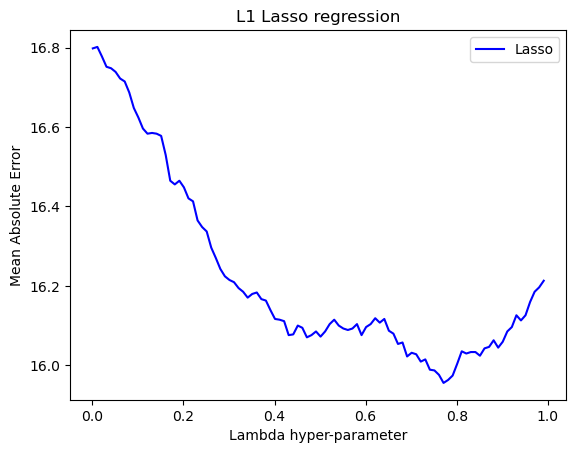

In [80]:
fig = plt.figure()   
ax1 = plt.plot(df_lasso['alpha_l1'],df_lasso['MAE_val_l1'],c='b',label='Lasso') 
plt.title('L1 Lasso regression')
plt.xlabel('Lambda hyper-parameter')
plt.ylabel('Mean Absolute Error')
plt.legend()

There seems to be no extreme outliers and no local extremes, so we can use these weights with the L1 model. We got better results using the X_train dataset without normalization, so let's remember the results and compare with the Ridge regression. 

#### L2 Ridge regression 

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. Here the highlighted part represents L2 regularization element.

$$
Loss =\|y - X\hat{w}\|^2 + \frac{1}{2}\lambda\|w\|^2
$$

* if λ is zero then you can imagine we get back ordinary least squares(OLS)
* if λ is very large then it will add too much weight and it will lead to under-fitting


In [ ]:
alphas = np.arange(1, 700, 1)  # hyperparameter matching
df_ridge = pd.DataFrame({"alpha_l2": alphas,
                         "MAE_train_l2": np.zeros(len(alphas)), 
                         "MAE_val_l2": np.zeros(len(alphas))})# creating a dataframe to store the results 

for a in tqdm(range(len(alphas))):
    alpha = alphas[a]
    ridge = Ridge(alpha = alpha)
    df_ridge.iloc[a] = [alpha] + metrics(ridge, mean_absolute_error)

In [47]:
df_ridge.sort_values(by = "MAE_val_l2").head(5) # the best shot is 15.74 with λ=635.00 (X_train dataset non normalized) and 16.14 with λ=0.001(X_train_features normalized)  

,alpha_l2,MAE_train_l2,MAE_val_l2
634,635,15.753968,15.738889
662,663,15.761111,15.742593
636,637,15.753175,15.742593
658,659,15.757143,15.744444
663,664,15.765079,15.744444


Knowing that large L2 coefficients can lead to overfitting, we must check for abnormally large coefficients

In [76]:
L2 = Ridge(alpha = 635)
metrics(L2,mean_absolute_error)
L2.coef_

Results on train set: 15.753968253968255
Results on test set: 15.738888888888889


array([ 1.87585645e-02,  6.09792099e-04,  0.00000000e+00,  8.01821449e-02,
       -6.82548481e-04,  0.00000000e+00, -1.28113348e-02, -8.67033310e-04,
        0.00000000e+00,  7.48397327e-03, -5.19884554e-04,  0.00000000e+00,
       -7.88169169e-02, -7.12516456e-04,  0.00000000e+00,  1.16898916e-01,
       -6.53861030e-04,  0.00000000e+00, -1.92592939e-02, -2.50000545e-03,
        0.00000000e+00,  5.71960938e-02, -7.33609088e-05,  0.00000000e+00,
        5.35598655e-02, -9.42939006e-04,  0.00000000e+00, -1.73133711e-02,
       -8.98087913e-04,  0.00000000e+00,  1.44721478e-01, -2.35754994e-03,
        0.00000000e+00, -1.17032935e-01, -1.18889270e-03,  0.00000000e+00,
        3.86114281e-02, -4.49268831e-03,  0.00000000e+00, -3.25262970e-02,
       -2.45250184e-03,  0.00000000e+00, -1.77388483e-02, -4.49088492e-03,
        0.00000000e+00, -7.27081948e-03, -1.39885719e-03,  0.00000000e+00,
       -2.78834610e-02, -2.89712439e-03,  0.00000000e+00, -1.27347608e-01,
       -7.50139134e-04,  

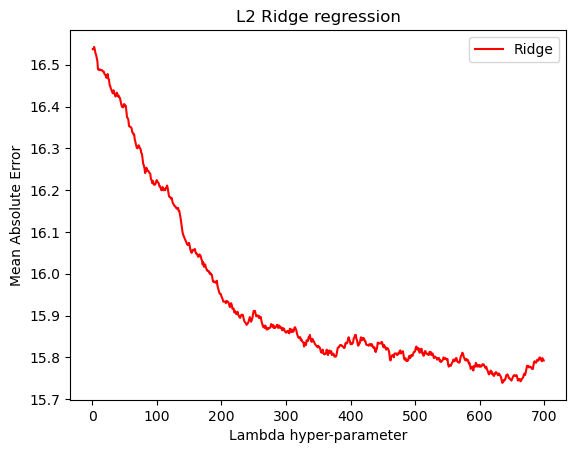

In [49]:
fig = plt.figure()  
ax2 = plt.plot(df_ridge['alpha_l2'],df_ridge['MAE_val_l2'],c='r',label='Ridge')
plt.title('L2 Ridge regression')
plt.xlabel('Lambda hyper-parameter')
plt.ylabel('Mean Absolute Error')
plt.legend()

We achieved an average absolute error of 15.74, which is the best result we got. However, λ is really big here, but in any case we checked the weights and they seem to be fine.

### Test prices forecasting

In [58]:
test[test['Price'].str.contains(':')].shape[0] # => we have 25 orderbooks in test set 

25

In [62]:
X_test, y_test = np.zeros((25, 1 + 3 * 40)), np.zeros(25) # creating empty arrays

In [64]:
orderbook_counter = 0 #  two counters for orderbooks and orders respectively 
order_counter = 0 

for i in tqdm(range(test.shape[0])): # filling the np.arrays 
    row = test.iloc[i]
    if 'price' not in row['Price']:
        X_test[orderbook_counter,order_counter:order_counter+3] = row.to_numpy() # the 'step' for each order is 3
        order_counter += 3
    elif 'price' in row['Price']:
        pred_order = row['Price'].split(':')[0]
        c = [0 if 'Sell' in pred_order else 1]
        X_test[orderbook_counter,-1] = c[0]
        orderbook_counter += 1
        order_counter = 0

100%|████████████████████████████████████| 1025/1025 [00:00<00:00, 11397.23it/s]


In [79]:
Results = 5 * L2.predict(X_test).astype(np.int32) # predicted prices

We received the final values, let's write them into the test.txt file

In [ ]:
file = open("test.txt", "r")
lines = file.readlines()

new_lines=[]
order_num = 0
for line in lines:
    if not 'price' in line:
        new_lines.append(line)
    if 'price' in line:
        new_lines.append((line.strip()+' '+str(Results[order_num])+'\n'))
        order_num += 1

file = open("test.txt", "w")
file.writelines(new_lines)

### Conclusion

We tested different linear regression models on different datasets, basic and updated with features, and we tried each set separately with and without normalization. In the end, we got the best results with the base non normalized dataset, which contains only prices, amounts, and orders, using the L2 model. The final average absolute error is 15.738889, which is 0.8037 less than what we got with the very first model. The regularization showed no significant improvement, although, predicting an accurate result, such values might be critical. 

### References

* Fragmentation, Price Formation, and Cross-Impact in Bitcoin Markets - Jakob Albers Department of Statistics, University of Oxford, Sam Howison, Mathematical Institute, University of Oxford Oxford, UK
* Aurélien Alfonsi, Antje Fruth, and Alexander Schied. Optimal execution strategies in limit order books with general shape functions. Quantitative Finance, 10(2):143–157, Jun 2009.
* Jean-Philippe Bouchaud, J. Farmer, and F. Lillo. How markets slowly digest changes in supply and demand. Capital Markets: Market Microstructure, 2008.
* Jean-Philippe Bouchaud, Marc Mézard, and Marc Potters. Statistical properties of stock order books: empirical results and models. Quantitative Finance, 2(4):251–256, Aug 2002.
* Rama Cont, Arseniy Kukanov, and Sasha Stoikov. The price impact of order book events. Journal of financial econometrics, 12(1):47–88, 2014.
